# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

В файле данных содержаться следующие признаки:

* DateCrawled — дата скачивания анкеты из базы
* VehicleType — тип автомобильного кузова
* RegistrationYear — год регистрации автомобиля
* Gearbox — тип коробки передач
* Power — мощность (л. с.)
* Model — модель автомобиля
* Kilometer — пробег (км)
* RegistrationMonth — месяц регистрации автомобиля
* FuelType — тип топлива
* Brand — марка автомобиля
* NotRepaired — была машина в ремонте или нет
* DateCreated — дата создания анкеты
* NumberOfPictures — количество фотографий автомобиля
* PostalCode — почтовый индекс владельца анкеты (пользователя)
* LastSeen — дата последней активности пользователя
* Price — цена (евро) - Целевой признак

План работы:
1. Подготовка данных
2. Обучение моделей
3. Анализ моделей

In [1]:
#!pip install catboost
#!pip install phik

In [2]:
import phik
import pandas as pd
import numpy as np
import lightgbm

from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV
from sklearn.preprocessing import OrdinalEncoder
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error as mse


## Подготовка данных

План подготовки данных
* Прочитать файл
* Вывести первые строки, информацию о таблицах, статистику по значениям 
* Проверить название столбцов, при необходимости привести к змеиному регистру
* Проверить наличие явных дубликатов, при необходимости обработать дубликаты
* Преобразовать типы данных, при необходимости
* Проверить наличие пропусков в данных, при необходимости обработать пропуски
* Проверить наличие выбросов, при необходимости обработать

In [3]:
df = pd.read_csv('f:/yandex-practicum/datasets/autos.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  NotRepaired        283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

In [4]:
df.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


In [5]:
df.describe()

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


Проблемы в числовых данных:
1. цена минимальная = 0
2. год регистрации с выбросами мин и макс, оставляю с 1900 по н.в.
3. мощность с выбросами мин и макс
4. месяц регистрации есть 0, вероятно не был указан, оставляю
5. количество изображений для всех = 0, исключаю из признаков

In [6]:
#приведение к змеиному регистру
df.columns = ['date_crawled', 'price', 'vehicle_type', 'registration_year', 'gearbox',
       'power', 'model', 'kilometer', 'registration_month', 'fuel_type', 'brand',
       'not_repaired', 'date_created', 'number_of_pictures', 'postal_code',
       'last_seen']

In [7]:
# удаление неинформативного столбца с нулевым количеством изображений
df.drop('number_of_pictures',axis=1,inplace=True)

In [8]:
#Перевод километража в тысячи км
df['kilometer'] = df['kilometer']/1000

In [9]:
# Поиск и удаление дубликатов
print(df.duplicated().sum())
df.drop_duplicates(inplace=True)

4


In [10]:
# перевод дат в datetime
df[['date_crawled','last_seen','date_created']]=df[['date_crawled','last_seen','date_created']].apply(pd.to_datetime)

In [11]:
df['last_seen'] = df['last_seen'].dt.year
df['date_crawled'] = df['date_crawled'].dt.year
df['date_created'] = df['date_created'].dt.year
df['car_age'] = df['date_created']-df['registration_year']


In [12]:
# Поиск пропусков
print(df.isna().sum()[df.isna().sum() != 0].sort_values(ascending=False)/df.shape[0])
print(df.isna().sum()[df.isna().sum() != 0].sort_values(ascending=False))


not_repaired    0.200793
vehicle_type    0.105795
fuel_type       0.092828
gearbox         0.055968
model           0.055607
dtype: float64
not_repaired    71154
vehicle_type    37490
fuel_type       32895
gearbox         19833
model           19705
dtype: int64


### Гистограммы, boxplot

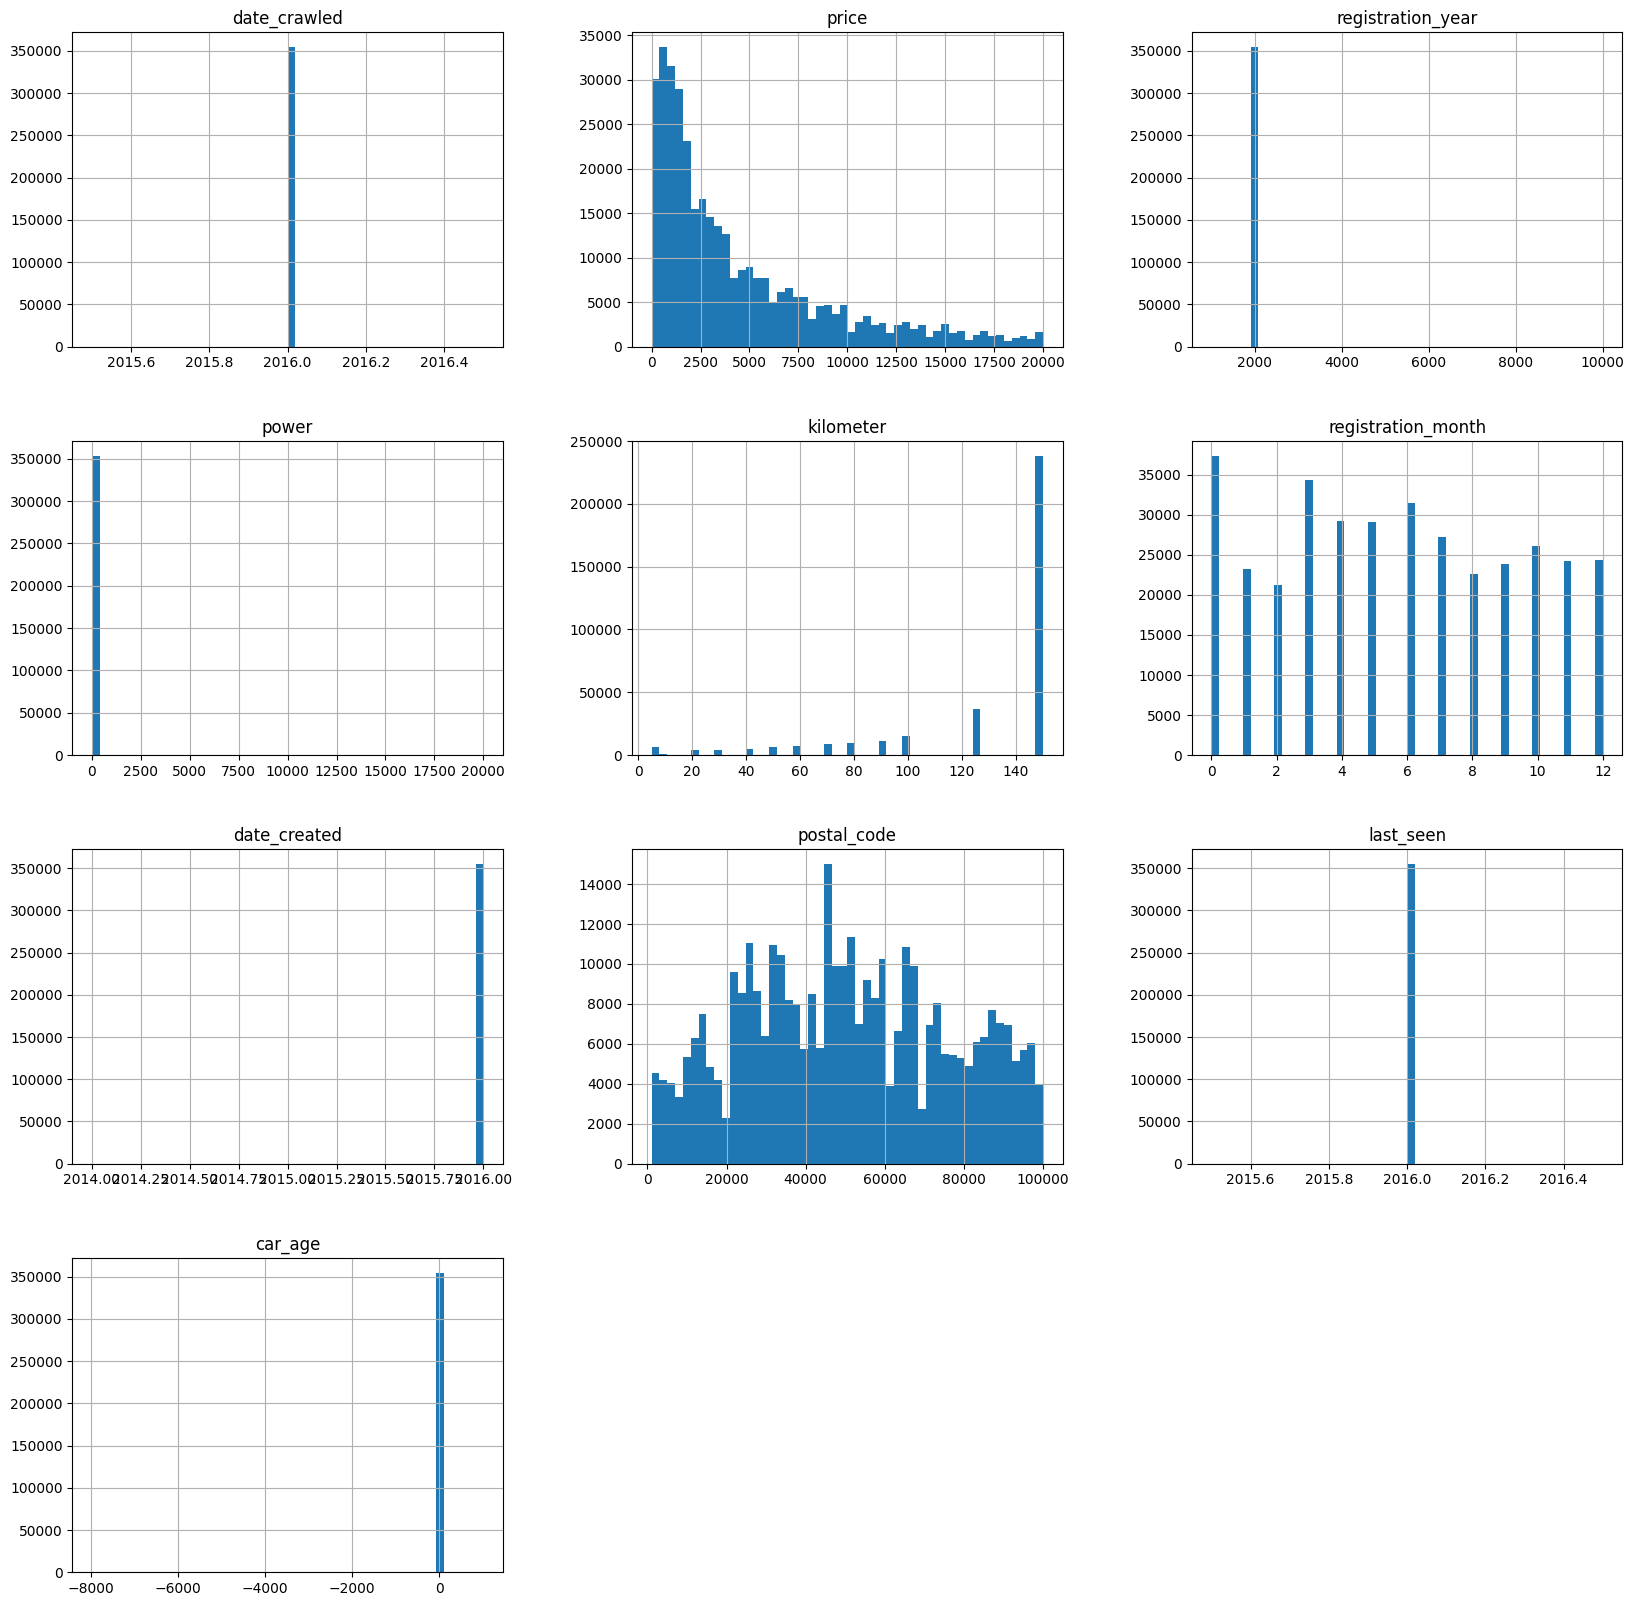

In [13]:
# Гистограммы и boxplot
df.hist(figsize=(20,20),bins=50);


<AxesSubplot:>

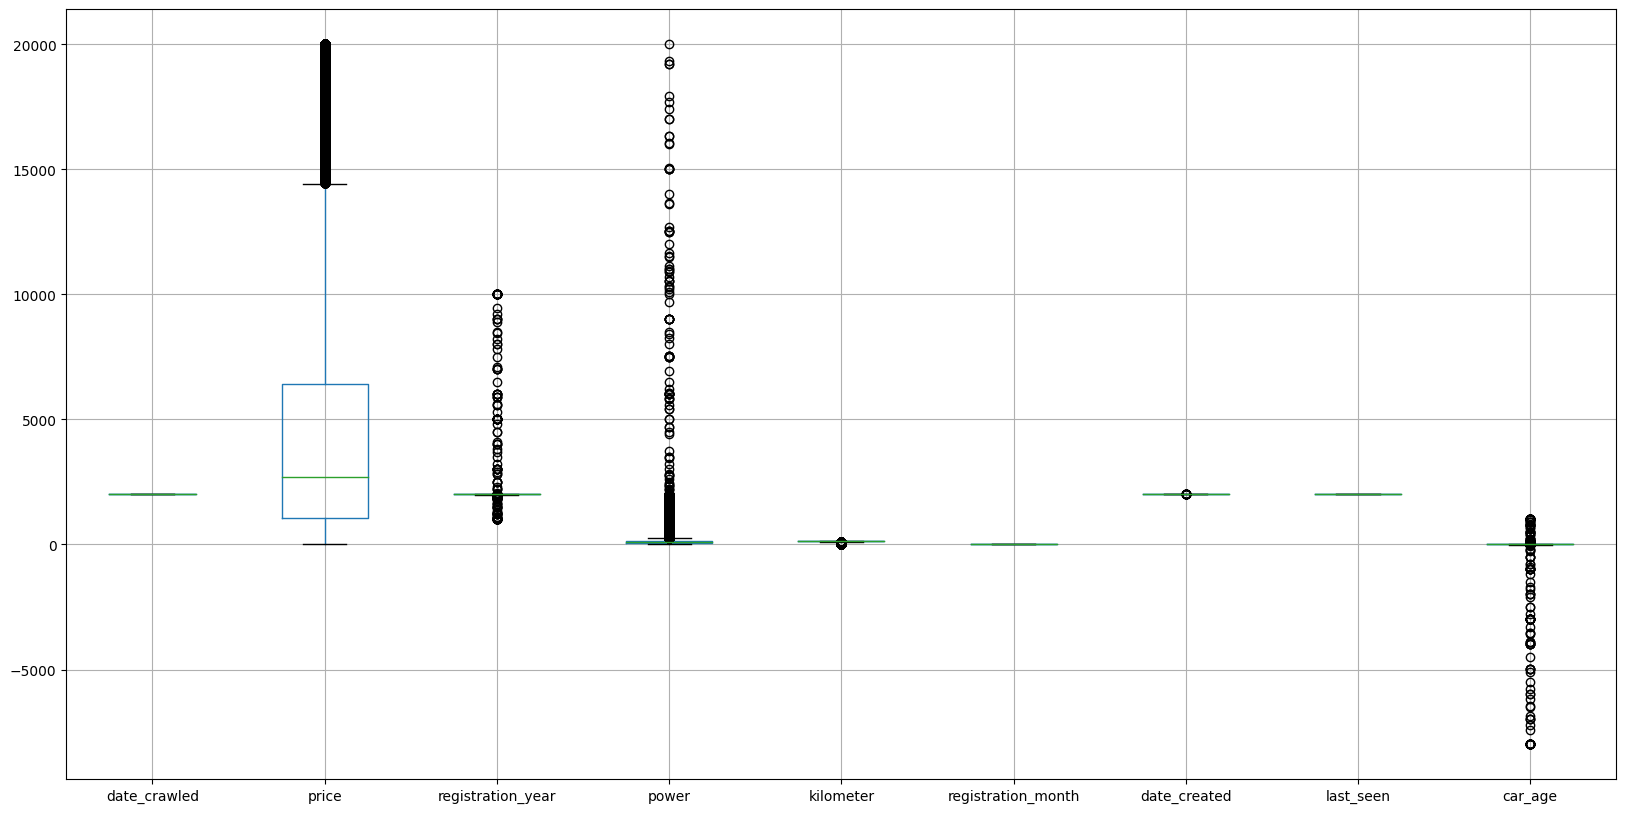

In [14]:
df.drop(['postal_code'],axis=1).boxplot(figsize=(20,10))#.set_ylim([0, 2000]) 

In [15]:
power_ceil = df["power"].quantile(q=0.75)+1.5*df["power"].std()
print(power_ceil)

427.7769954693977


In [16]:
df.groupby('model').count()['price'].sort_values()

model
range_rover_evoque        2
serie_1                   2
rangerover                4
serie_3                   4
serie_2                   8
                      ...  
corsa                 12570
polo                  13066
3er                   19761
other                 24420
golf                  29232
Name: price, Length: 250, dtype: int64

In [17]:
# поиск самой маломощной машины
df.pivot_table(index='model', values='power', aggfunc=['median','min','mean','max']).sort_values(('median','power'))


,median,min,mean,max
,power,power,power,power
model,,,,
samara,0.0,0,26.230769,75
serie_1,0.0,0,0.000000,0
601,26.0,0,15.844869,50
kaefer,34.0,0,35.149321,1300
move,42.0,0,42.350000,91
...,...,...,...,...
range_rover_evoque,296.0,296,296.000000,296
cl,306.0,0,240.143478,508


In [18]:
# просмотр цен моделей машины
df.pivot_table(index='model', values='price', aggfunc=['median','min','mean','max']).sort_values(('median','price'))


,median,min,mean,max
,price,price,price,price
model,,,,
samara,300.0,0,680.307692,2199
move,500.0,0,606.366667,2500
elefantino,550.0,80,522.636364,1100
escort,550.0,0,837.238674,14900
charade,550.0,150,1236.518519,9400
...,...,...,...,...
q5,16499.0,65,15843.989691,20000
a5,16500.0,0,15531.853211,20000


### Обработка выбросов, аномалий и пропусков, scater matrix

In [19]:
# Обработка выбросов и аномалий
print('Было моделей:',len(df['model'].unique()),'брендов:',len(df['brand'].unique()))
df = df.query('(price > 100) and (power <= 600) and (power >= 26) and (registration_year > 1960) and (registration_year < 2017)')
df.dropna(inplace=True)
print('После обработки осталось моделей:',len(df['model'].unique()),'брендов:',len(df['brand'].unique()))

Было моделей: 251 брендов: 40
После обработки осталось моделей: 249 брендов: 39


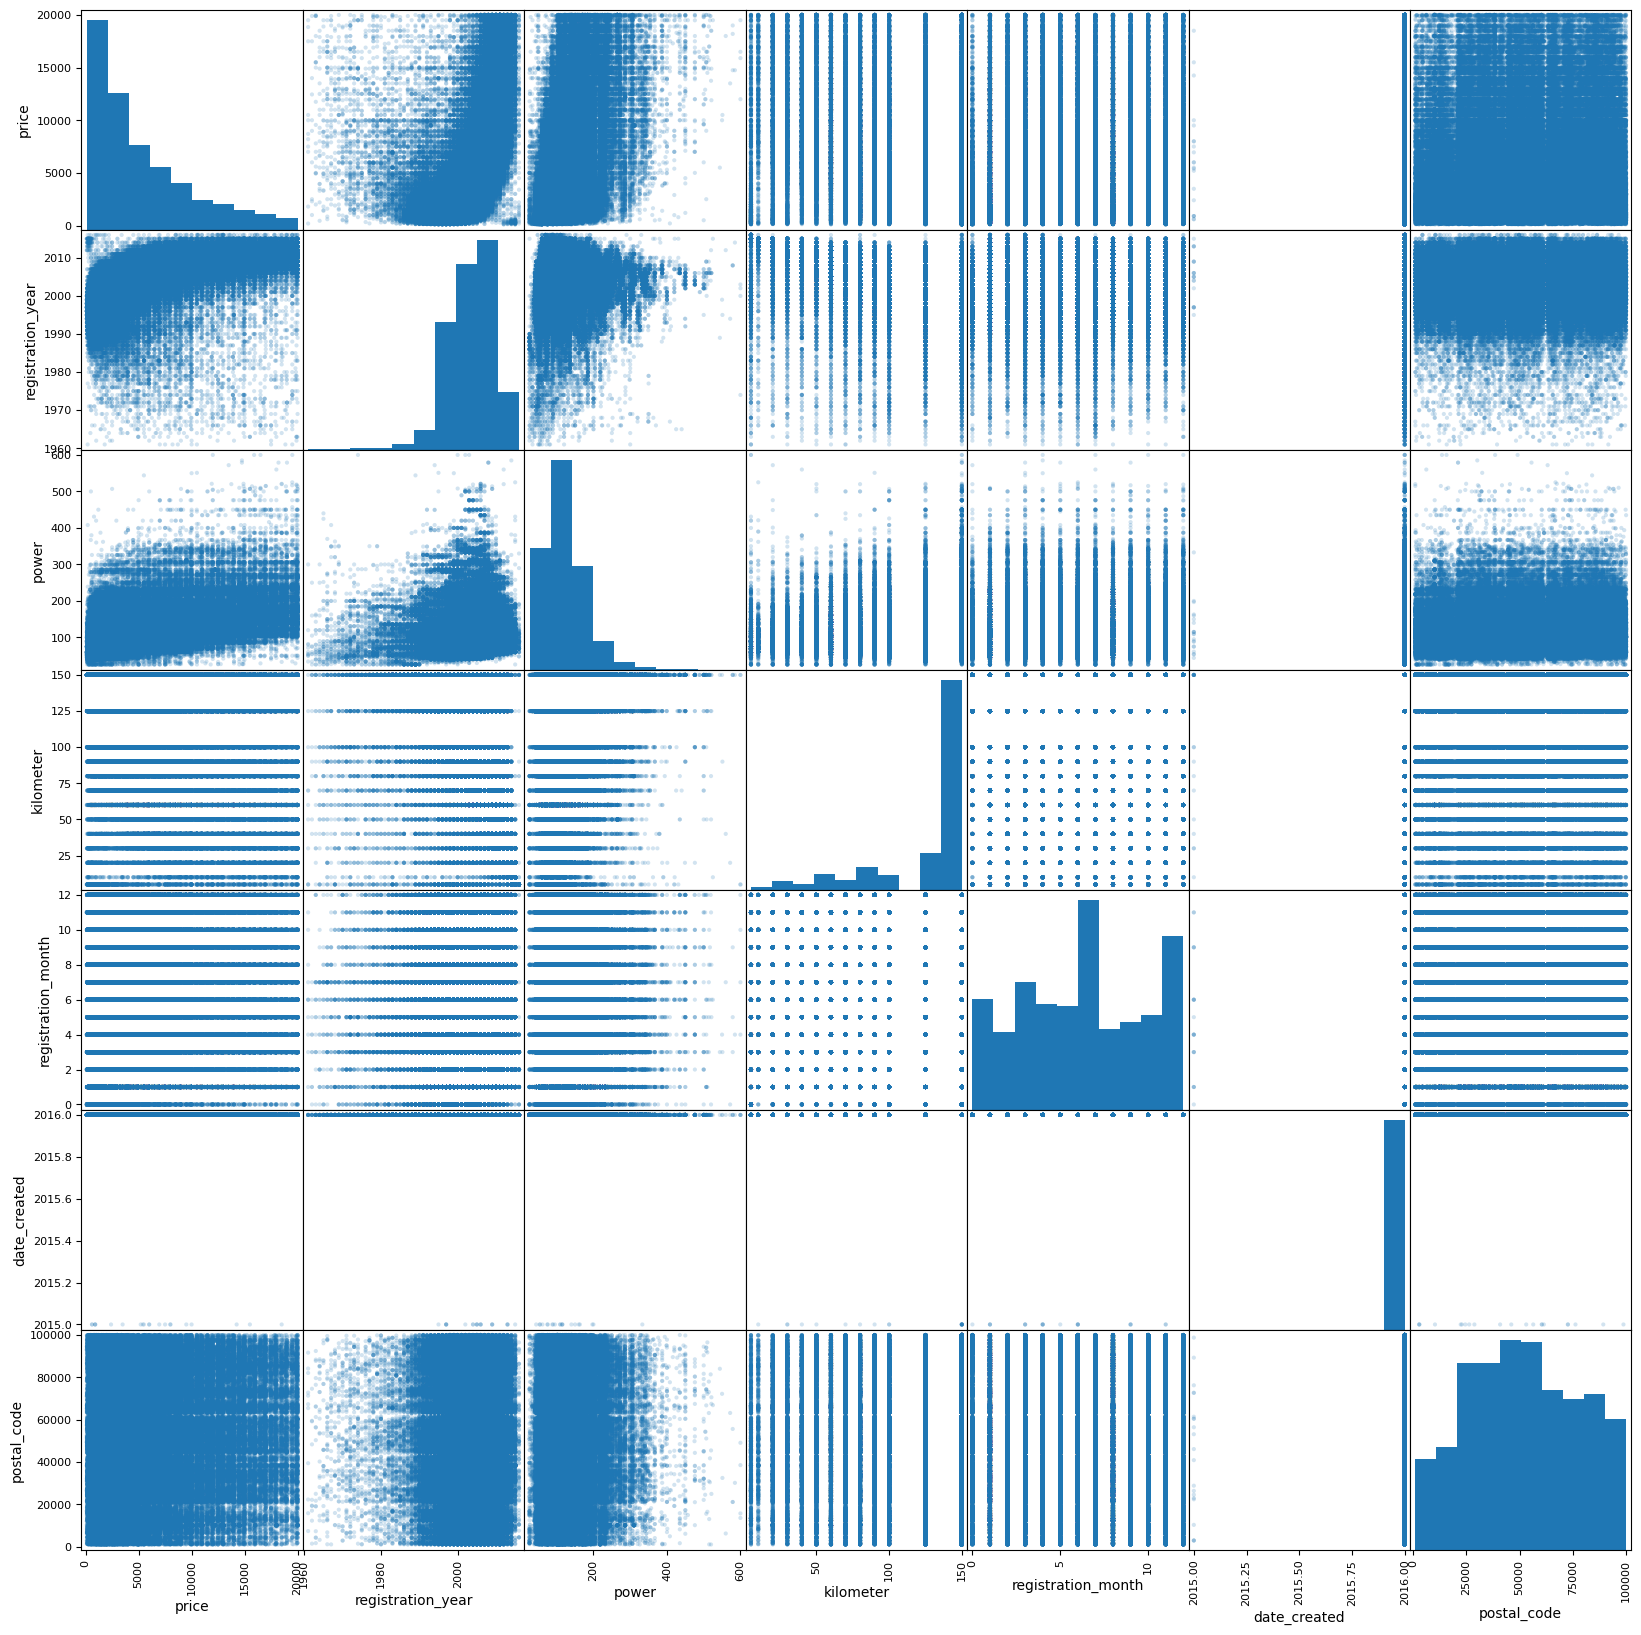

In [20]:
pd.plotting.scatter_matrix(df.drop(['last_seen','date_crawled','car_age'], axis=1), alpha=0.2,figsize=(20,20))[0];

In [21]:
df.corr()['price']

date_crawled               NaN
price                 1.000000
registration_year     0.574435
power                 0.506072
kilometer            -0.408067
registration_month    0.034680
date_created         -0.002357
postal_code           0.058066
last_seen                  NaN
car_age              -0.574435
Name: price, dtype: float64

### Вывод
1. Загружен файл с данными. В файле содержаться следующие данные: 

Признаки
* DateCrawled — дата скачивания анкеты из базы
* VehicleType — тип автомобильного кузова
* RegistrationYear — год регистрации автомобиля
* Gearbox — тип коробки передач
* Power — мощность (л. с.)
* Model — модель автомобиля
* Kilometer — пробег (км)
* RegistrationMonth — месяц регистрации автомобиля
* FuelType — тип топлива
* Brand — марка автомобиля
* NotRepaired — была машина в ремонте или нет
* DateCreated — дата создания анкеты
* NumberOfPictures — количество фотографий автомобиля
* PostalCode — почтовый индекс владельца анкеты (пользователя)
* LastSeen — дата последней активности пользователя

Целевой признак

* Price — цена (евро)

2. Просмотрены первые строки, информация о таблице, статистика по числовым значениям. Выявлены следующие проблемы в числовых данных:
* цена минимальная = 0
* год регистрации с выбросами мин и макс
* мощность с выбросами мин и макс
* месяц регистрации есть 0, вероятно не был указан, оставлен
* количество изображений для всех = 0, исключен из признаков

3. Названия всех столбцов не в змеином регистре, приведены к змеиному регистру.
4. Найдены и удалены 4 явных дубликата.
5. Преобразованы даты в datetime, определены периоды времени между датами выгрузки, последней активностью и датой создания объявления. Из трех признаков  два (дата выгрузки и дата последней активности) перезаписаны значениями в днях (int) с даты размещения объявления.

Признак количество изобржений удален, т.к. он неиформативен - по всех записях равен 0.

Признак километраж для удобства переведен из километров в тыс км 

6. В категориальных признаках имеется значительное количество пропусков от 5 до 20 % от общей выборки. 

Обработка пропусков, выбросов и аномалий.

Данных много, поэтому все пропуски удалены, чтобы обучать модели на наиболее достоверных данных. 
    
Выбросы и аномалии:
* год производства оставлены машины выпущенные в 1960-2016 г.
* мощность оставил от 26 л.с. до 600
* оставлены машины стоимостью от 100 евро, с запасом от медиана самой дешевой машины (самара - 300 у.е.).

В результате обработки пропала одна модель serie_1, записи с которой имеют нулевую мощность.
    
Рассмотрена корреляция и матрица рассеивания для числовых признаков. Признаки с высокой корреляцией год регистрации, мощность, километраж. Слабая корреляция для месяца регистрации (0.034) и индекса продавца (0.058). Ряд индексов не имеет высоких цен, индекс - категориальная переменная, есть белые области на графике рассеяния, поэтому признак оставил до просмотра важности признаков моделей.

Расчитан возраст авто, вычтя из года создания объявления год регистрации авто. Корреляция с ценой такая же как и для года регистрации. Дальше не используется для этого датасета.

Неинформативные признаки: в данной выборке все признаки даты-времени, кроме года выпуска (или возраста авто).

## Обучение и анализ моделей

План
* Обработка категориальных признаков, Подготовка выборок обучающей и тестовой
* Создание моделей регрессии с преудстановленными гиперпараметрами:
1. CatBoostRegressor
2. LGBMRegressor
3. Дерево решений
4. Случайный лес
5. Линейная регрессия

* Обучение моделей регрессии, замер времени обучения
* Оценка качества моделей регрессии, замер времени предсказания, сравнение с константой моделью




### Подготовка категориальных данных, обучающей и тестовой выборок

In [22]:
#  phi Корреляция всех признаков
interval_cols = [ 'price', 'registration_year',
                 'power', 'kilometer', 'registration_month', 'date_created', 'car_age']
df.drop(['date_crawled', 'last_seen','postal_code'],axis=1).phik_matrix(interval_cols=interval_cols)['price']

price                 1.000000
vehicle_type          0.263775
registration_year     0.690596
gearbox               0.323602
power                 0.498983
model                 0.577217
kilometer             0.319551
registration_month    0.066857
fuel_type             0.252335
brand                 0.338028
not_repaired          0.339645
date_created               NaN
car_age               0.690510
Name: price, dtype: float64

In [23]:
cat_features = ['vehicle_type',  'gearbox', 'model', 'fuel_type', 'brand', 'not_repaired']

encoder = OrdinalEncoder()
encoder.fit(df[cat_features])
df[cat_features] = encoder.transform(df[cat_features])


# OHE кодирование признаков
#df = pd.get_dummies(df, columns=cat_features, drop_first=True)

array([<AxesSubplot:xlabel='price', ylabel='price'>,
       <AxesSubplot:xlabel='vehicle_type', ylabel='price'>,
       <AxesSubplot:xlabel='gearbox', ylabel='price'>,
       <AxesSubplot:xlabel='model', ylabel='price'>,
       <AxesSubplot:xlabel='fuel_type', ylabel='price'>,
       <AxesSubplot:xlabel='brand', ylabel='price'>,
       <AxesSubplot:xlabel='not_repaired', ylabel='price'>], dtype=object)

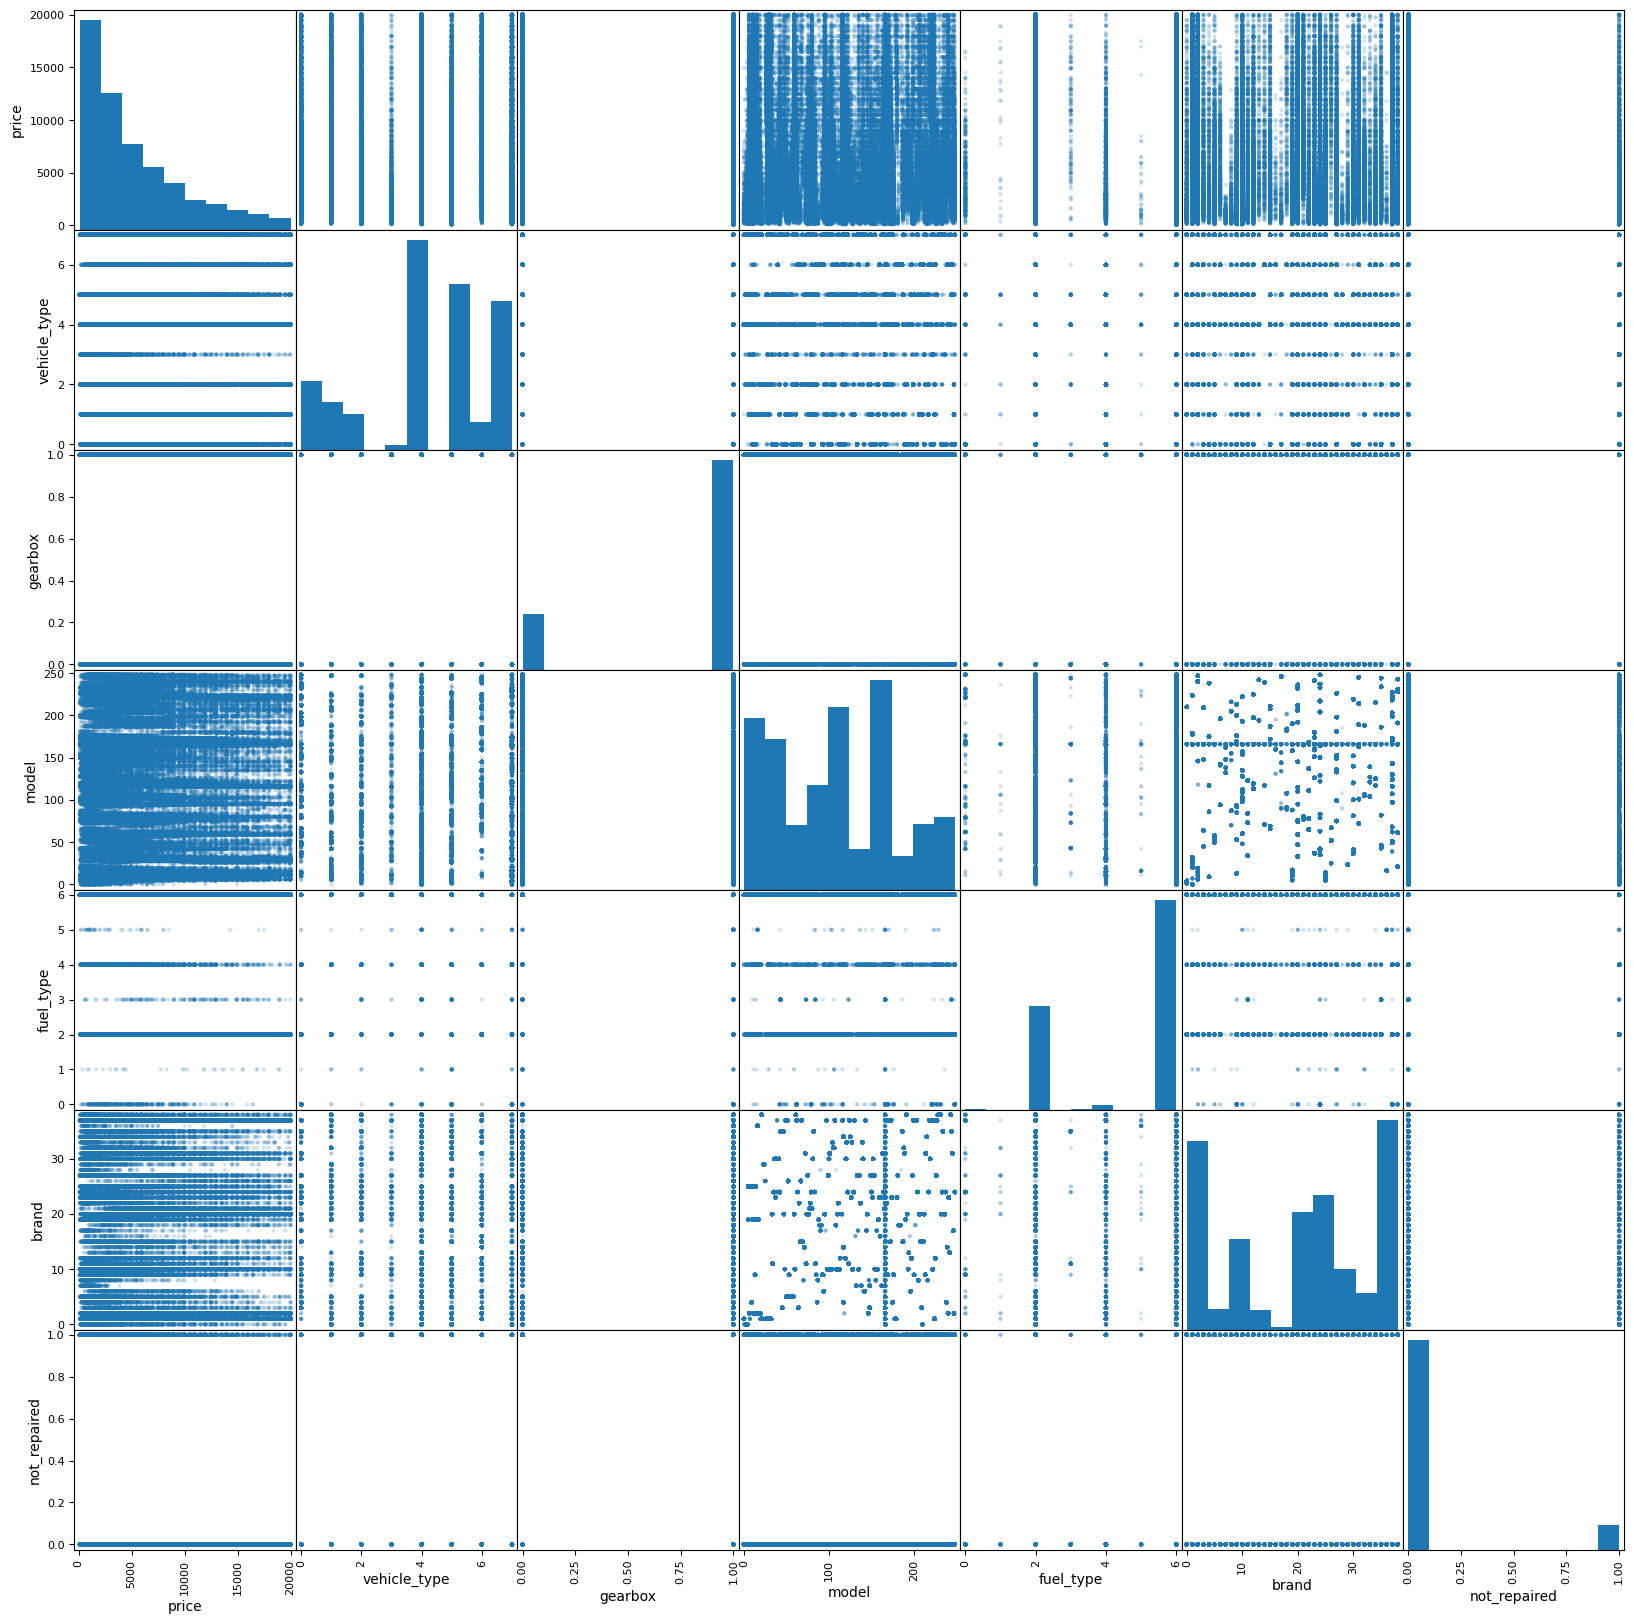

In [24]:
pd.plotting.scatter_matrix(df[['price', 'vehicle_type',  'gearbox', 'model', 'fuel_type', 'brand', 'not_repaired']], alpha=0.2,figsize=(20,20))[0]

Рассчитана phik корреляция для всех признаков. Построена матрица распределений. Закодированные категориальные признаки (кроме типа коробки) визуально информативны. Однако автоматическая коробка предположительно должна увеличивать стоимость, поэтому все категориальные признаки пока оставлены.

В моделях авто есть записи "Other", которые присутствуют для многих брендов

In [25]:
features = df[['registration_year', 'power', 'kilometer', 'postal_code', 'vehicle_type',  'gearbox', 'model', 'fuel_type', 'brand', 'not_repaired']]
target = df['price']

features_train,features_test,target_train,target_test = train_test_split(features,target,test_size=0.25,random_state=12345)

### Создание моделей

In [26]:
model = {}
#(CatBoostRegressor, LGBMRegressor, DecisionTreeRegressor, RandomForestRegressor, LinearRegression)

model['CBR'] = CatBoostRegressor(random_state=12345, silent=True)
model['LGBMR'] = LGBMRegressor(random_state=12345)
model['DTR'] = DecisionTreeRegressor(random_state=12345)
model['RFR'] = RandomForestRegressor(random_state=12345)
model['LR'] = LinearRegression()

### Обучение моделей

In [27]:
for model_type in ['CBR','LGBMR','DTR','RFR','LR']:
    %time model[model_type].fit(features_train,target_train)

CPU times: total: 1min 59s
Wall time: 11.1 s
CPU times: total: 4.17 s
Wall time: 351 ms
CPU times: total: 2.33 s
Wall time: 739 ms
CPU times: total: 45.8 s
Wall time: 45.8 s
CPU times: total: 31.2 ms
Wall time: 65.4 ms


Результат 

CPU times: user 22 s, sys: 156 ms, total: 22.1 s
Wall time: 23.1 s

CPU times: user 3.62 s, sys: 72 ms, total: 3.69 s
Wall time: 3.71 s

CPU times: user 865 ms, sys: 28 ms, total: 893 ms
Wall time: 947 ms

CPU times: user 54.4 s, sys: 803 ms, total: 55.2 s
Wall time: 55.3 s

CPU times: user 51.7 ms, sys: 15.9 ms, total: 67.6 ms
Wall time: 46.1 ms

### Важность признаков моделей

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

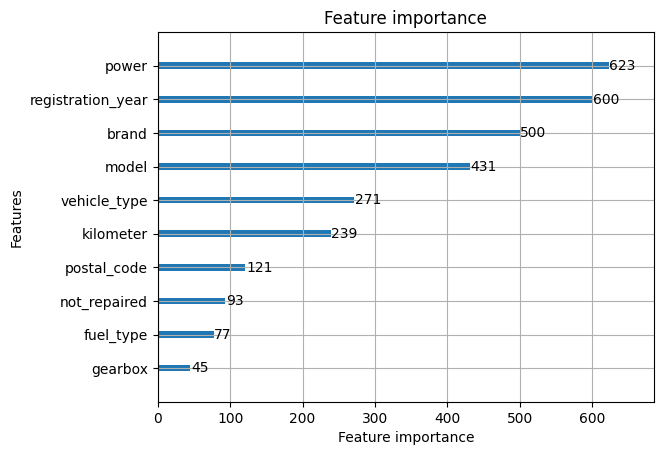

In [28]:
# важность признаков LGBMR
lightgbm.plot_importance(model['LGBMR'])

In [29]:
# важность признаков CBR
pd.DataFrame({'feature_names': features_train.columns,
              'feature_importance': model['CBR'].get_feature_importance()}
            ).sort_values(by=['feature_importance'], ascending=False)

,feature_names,feature_importance
0,registration_year,36.154907
1,power,29.550036
8,brand,10.898452
2,kilometer,6.509911
4,vehicle_type,6.312883
6,model,4.441067
9,not_repaired,2.414197
7,fuel_type,1.638647
3,postal_code,1.298714
5,gearbox,0.781186


### Предсказание моделей

In [30]:
# оценка времен предсказания моделей
predict={}
for model_type in ['CBR','LGBMR','DTR','RFR','LR']:
    %time predict[model_type] = model[model_type].predict(features_test)

CPU times: total: 234 ms
Wall time: 16.4 ms
CPU times: total: 719 ms
Wall time: 36 ms
CPU times: total: 250 ms
Wall time: 29 ms
CPU times: total: 2.91 s
Wall time: 1.71 s
CPU times: total: 0 ns
Wall time: 11.1 ms


Результат

CPU times: user 128 ms, sys: 11 ms, total: 139 ms
Wall time: 80.9 ms

CPU times: user 512 ms, sys: 0 ns, total: 512 ms
Wall time: 272 ms

CPU times: user 38 ms, sys: 0 ns, total: 38 ms
Wall time: 37.5 ms

CPU times: user 2.99 s, sys: 9.6 ms, total: 3 s
Wall time: 3 s

CPU times: user 4.58 ms, sys: 50 µs, total: 4.63 ms
Wall time: 4.3 ms

### Качество моделей

In [31]:
# качество на тестовой выборке
print('RMSE моделей:')
for model_type in ['CBR','LGBMR','DTR','RFR','LR']:
    print(model_type, ' - ', mse(target_test, predict[model_type],squared=False)) #.floor()

RMSE моделей:
CBR  -  1543.6064642381962
LGBMR  -  1631.3636377976345
DTR  -  2041.6763246329022
RFR  -  1537.7211858297994
LR  -  2846.8998770399553


In [32]:
# качество при кросс-валидации
for model_type in ['CBR','LGBMR','DTR','RFR','LR']:
    %time scores = cross_val_score(model[model_type], features_train, target_train, scoring='neg_root_mean_squared_error', cv=5, n_jobs=-1)
    print(f'RMSE модели {model_type}: {-scores.mean()}')

CPU times: total: 109 ms
Wall time: 24.3 s
RMSE модели CBR: 1566.4382551237813
CPU times: total: 46.9 ms
Wall time: 1.83 s
RMSE модели LGBMR: 1652.9975319995233
CPU times: total: 46.9 ms
Wall time: 1.08 s
RMSE модели DTR: 2073.581893120106
CPU times: total: 93.8 ms
Wall time: 51.3 s
RMSE модели RFR: 1562.5320803583095
CPU times: total: 46.9 ms
Wall time: 316 ms
RMSE модели LR: 2851.6409113750806


In [33]:
# Качество RMSE константной модели
mse(target_test, pd.Series(target_train.mean(),features_test.index),squared=False)

4730.2855838435535

Результат

RMSE моделей:

CBR  -  1552 (cv - 1556)

LGBMR  -  1643 (cv - 1646)

DTR  -  2018 (cv - 2072)

RFR  -  1533 (cv - 1567)

LR  -  2837 (cv - 2848)

Constant 4728

### Вывод
* Для категориальных признаков применено порядковое кодирование. Подготовлены обучающая и тестовая выборки
* Созданы модели регрессии с преудстановленными гиперпараметрами:
1. CatBoostRegressor
2. LGBMRegressor
3. Дерево решений
4. Случайный лес
5. Линейная регрессия

* Модели обучены, измерено время обучения
* По тестовой выборке определено время предсказания, а также качество моделей.
* проведена проверка качества с помощью кросс-валидации**

**Лучшее качество** имеет модель CatBoostRegressor (RMSE на тестовой 1552, на кросс-валидационной 1556), затем модели Случаного леса (1533/1567), LGBMRegressor (1643/1646), Дерево решений (2018/2072), Линейная регрессия (2837/2848). RMSE Константной модели - 4728. 

**Наименьшее время предсказания** у модели Линейная регрессия (4.3 ms), затем Дерево решений (37.5 ms), CatBoostRegressor (80.9 ms), LGBMRegressor (272 ms), Случаный лес (3 s)

**Наименьшее время обучения** у модели Линейная регрессия (46.1 ms), затем  Дерево решений (947 ms), LGBMRegressor (3.71 s),CatBoostRegressor (23.1 s), Случаный лес (55.3 s)

Таким образом, модель CatBoostRegressor имеет лучшее качество при кросс-валидации, малое время предсказания, но долго обучается. Модели Линейной регрессии и Решающего дерева имеют наихудшее качество. 


## Исследование гиперпараметров модели
Рассмотреть влияние гиперпараметров на качество моделей LGBMRegressor и CatBoostRegressor

In [34]:
%%time
# Run RandomizedSearchCV to tune the hyper-parameter
model1=LGBMRegressor()
k_fold_cv = 3 
params = {
 "n_estimators" : [50, 100, 500],
 "max_depth" : [9, 10, 11, 12, 13],
 #"learning_rate" : [0.01, 0.1, 0.2, 0.3, 1.0]
 }
random = RandomizedSearchCV(model1, param_distributions=params, cv=k_fold_cv,
 n_iter = 5, scoring='neg_root_mean_squared_error',verbose=2, random_state=12345,
 n_jobs=-1, return_train_score=True)
random.fit(features_train, target_train)
print("Best hyper parameter:", random.best_params_)
print("Best hyper score:", -random.best_score_)

Fitting 3 folds for each of 5 candidates, totalling 15 fits
Best hyper parameter: {'n_estimators': 500, 'max_depth': 11}
Best hyper score: 1552.9573545702096
CPU times: total: 13.6 s
Wall time: 10.5 s


In [35]:
# Оценка времени обучения и предсказания
%time random.best_estimator_.fit(features_train,target_train)
%time random.best_estimator_.predict(features_test)

CPU times: total: 15 s
Wall time: 951 ms
CPU times: total: 2.14 s
Wall time: 142 ms


array([ 2611.56538973,  6358.23180518,  8521.63001209, ...,
         578.3088454 ,  8328.13031842, 11322.36951129])

In [36]:
%%time
# Run RandomizedSearchCV to tune the hyper-parameter
model2 = CatBoostRegressor(random_state=12345, silent=True)

k_fold_cv = 3 
params = {
 "n_estimators" : [50, 100, 500],
 "max_depth" : [9, 10, 11, 12, 13],
 #"learning_rate" : [0.01, 0.1, 0.2, 0.3, 1.0]
 }
random = RandomizedSearchCV(model2, param_distributions=params, cv=k_fold_cv,
 n_iter = 5, scoring='neg_root_mean_squared_error',verbose=2, random_state=12345,
 n_jobs=-1, return_train_score=True)
random.fit(features_train, target_train)
print("Best hyper parameter:", random.best_params_)
print("Best hyper score:", -random.best_score_)


Fitting 3 folds for each of 5 candidates, totalling 15 fits
Best hyper parameter: {'n_estimators': 500, 'max_depth': 12}
Best hyper score: 1524.3064909172308
CPU times: total: 2min 29s
Wall time: 1min 37s


In [ ]:
%time random.best_estimator_.fit(features_train,target_train)
%time random.best_estimator_.predict(features_test)

CPU times: total: 2min 27s
Wall time: 28.3 s
CPU times: total: 500 ms
Wall time: 32 ms


array([ 2511.22524875,  6521.21164983,  8388.97512555, ...,
         429.88242288,  8349.86941362, 11285.58193935])

In [38]:
# проверка модели с исключенным признаком индекс
%time random = RandomizedSearchCV(model2, param_distributions=params, cv=k_fold_cv, n_iter = 5, scoring='neg_root_mean_squared_error',verbose=2, random_state=12345, n_jobs=-1, return_train_score=True)
%time random.fit(features_train.drop('postal_code',axis=1), target_train)
print("Best hyper parameter:", random.best_params_)
print("Best hyper score:", -random.best_score_)

CPU times: total: 15.6 ms
Wall time: 6.97 ms
Fitting 3 folds for each of 5 candidates, totalling 15 fits
CPU times: total: 2min 2s
Wall time: 1min 19s
Best hyper parameter: {'n_estimators': 500, 'max_depth': 12}
Best hyper score: 1521.726288369014


In [39]:
%time random.best_estimator_.fit(features_train.drop('postal_code',axis=1),target_train)
%time random.best_estimator_.predict(features_test)

CPU times: total: 2min 6s
Wall time: 25.6 s
CPU times: total: 281 ms
Wall time: 32 ms


array([ 2538.44794012,  6677.23187219,  8346.3243487 , ...,
         457.73368931,  8431.47997751, 11779.78619782])

### Вывод
Выполнен случайный подбор параметров моделей LGBMRegressor и CatBoostRegressor.
Диапазоны параметров n_estimators : [50, 100, 500], max_depth : [9,  10, 11, 12, 13].

Результаты случайного подбора:

**LGBMRegressor:** лучшие параметры max_depth=12, n_estimators=500, CV_RMSE=1542, время обучения 4.31 s, время предсказания 1.74 s

**CatBoostRegressor:** лучшие параметры max_depth=12, n_estimators=500, CV_RMSE=1501,  время обучения 48 s, время предсказания 176 ms

Таким образом, из рассматриваемых моделей рекомендуется модель CatBoostRegressor, имеющую наилучшее качество, высокую скорость предсказания (в \~10 раз быстрее LGBMRegressor), но примерно в 10 раз дольшее обучение (чем LGBMRegressor).

## Общий вывод

1. Загружены, проанализированы и подготовлены данные объявлений о продаже машин
2. Обучены 5 различных моделей регрессии с предустановленными гиперпараметрами. Лучшее качество у модели CatBoostRegressor.
3. Выполнен случайный подбор параметров моделей LGBMRegressor и CatBoostRegressor. Рекомендована модель CatBoostRegressor.